In [117]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

# Import Sionna functions
import sionna

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL, PanelArray, UMi
from sionna.channel import OFDMChannel, GenerateFlatFadingChannel, FlatFadingChannel, ApplyFlatFadingChannel,RayleighBlockFading
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper, LinearInterpolator
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, qam, Constellation
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber, BinarySource, QAMSource, ebnodb2no

In [118]:
num_ut = 1 # número de 'user terminals', nesse caso foi considerado como o transmissor 
num_bs = 1 # número de 'base stations' , nesse caso foi considerado como receptor
num_ut_ant = 1 # antenas de 'ut'
num_bs_ant = 1 # antes de 'bs'
num_streams_per_tx = num_ut_ant
NUM_BITS_PER_SYMBOL = 4 # número de bits por símbolo (2^6) = 256AM
CODERATE = 1/2 #taxa de código
BATCH_SIZE = 128 # número de simulações feitas em paralelo 
binary_source = BinarySource(); # origem de bits 
rx_tx_association = np.array([[1]]) # associação entre rx_tx, nesse caso existe 1 tx para cada rx.

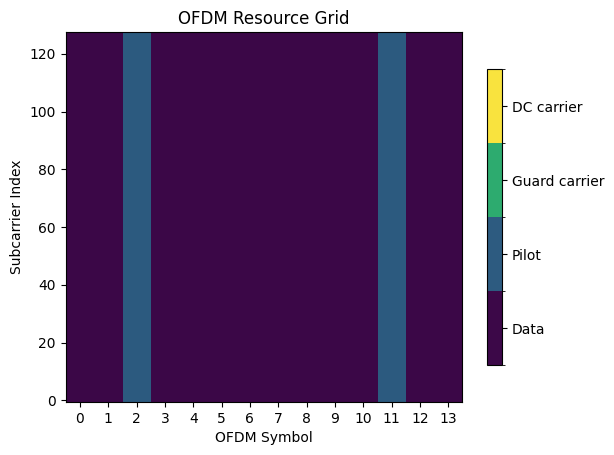

In [119]:
# define o resource grid a ser usado no canal OFDM
rg = ResourceGrid(num_ofdm_symbols=14,
                                      fft_size=128,
                                      subcarrier_spacing=30e3,
                                      num_tx=num_ut,
                                      num_streams_per_tx=num_streams_per_tx,
                                      cyclic_prefix_length=6,
                                      pilot_pattern='kronecker',
                                      pilot_ofdm_symbol_indices=[2,11])
rg.show();

In [120]:
sm = StreamManagement(rx_tx_association=rx_tx_association,num_streams_per_tx=num_ut_ant) # a função stream management diz quais antenas de transmissão comunicam os dados com as antenas  de recepção. 

In [121]:
rg_mapper = ResourceGridMapper(rg)

In [122]:
channel_model = RayleighBlockFading(num_rx = num_bs,num_rx_ant = num_bs_ant, num_tx = num_ut, num_tx_ant = num_ut_ant) 
# Modelo de canal escolhido (Mais simples entre os canais disponiveis para simular uma transmissão OFDM, não necessita de parâmetros com arranjos de antenas)

In [123]:
channel = OFDMChannel(channel_model, rg, add_awgn = True, normalize_channel = True, return_channel = True)
# Modelo de canal no domínio da frequência

In [124]:
ls_est = LSChannelEstimator(rg,interpolation_type='nn', interpolator=None)
# Usa o método de estimação de canal por mínimos quadrados, usa a interpolação do tipo ''nearest-neighbor''

In [125]:
lmmse_equ = LMMSEEqualizer(rg, sm) # linear minimum mean squared error
n = int(rg.num_data_symbols*NUM_BITS_PER_SYMBOL)
k = int(n*CODERATE)

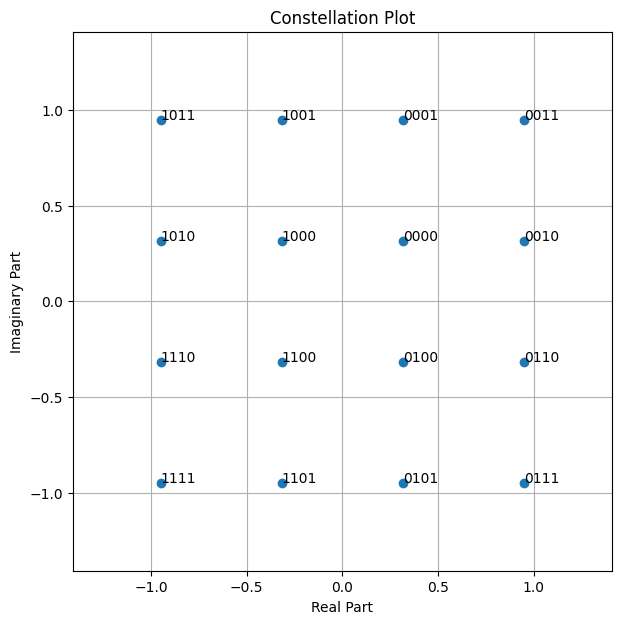

In [126]:
encoder = LDPC5GEncoder(k, n) # pesquisar sobre
decoder = LDPC5GDecoder(encoder, hard_out=True) # pesquisar sobre
constellation = Constellation(constellation_type='qam',num_bits_per_symbol=NUM_BITS_PER_SYMBOL) # constelação do sinal
mapper = Mapper(constellation=constellation) # mapeia tensores binários da constelação (pesquisar sobre tensores binários)
demapper = Demapper("app",constellation=constellation) # demapeia
constellation.show();

In [127]:
#densidade espectral de ruído
no = ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE,
                        resource_grid=rg)

# Transmissor
bits = binary_source([BATCH_SIZE, num_ut, rg.num_streams_per_tx, k])
print("Shape of bits: ", bits.shape)
codewords = encoder(bits)
print("Shape of codewords: ", codewords.shape)
x = mapper(codewords)
print("Shape of x: ", x.shape)
x_rg = rg_mapper(x)
print("Shape of x_rg: ", x_rg.shape)

# Canal
y, h_freq = channel([x_rg, no])
print("Shape of y_rg: ", y.shape)
# Receptor
h_hat, err_var = ls_est([y, no])
print("Shape of h_hat: ", h_hat.shape)
print("Shape of err_var: ", err_var.shape)
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
print("Shape of x_hat: ", x_hat.shape)
print("Shape of no_eff: ", no_eff.shape)
llr = demapper([x_hat, no_eff])
print("Shape of llr: ", llr.shape)
bits_hat = decoder(llr)
print("Shape of bits_hat: ", bits_hat.shape)

Shape of bits:  (128, 1, 1, 3072)
Shape of codewords:  (128, 1, 1, 6144)
Shape of x:  (128, 1, 1, 1536)
Shape of x_rg:  (128, 1, 1, 14, 128)
Shape of y_rg:  (128, 1, 1, 14, 128)
Shape of h_hat:  (128, 1, 1, 1, 1, 14, 128)
Shape of err_var:  (1, 1, 1, 1, 1, 14, 128)
Shape of x_hat:  (128, 1, 1, 1536)
Shape of no_eff:  (128, 1, 1, 1536)
Shape of llr:  (128, 1, 1, 6144)
Shape of bits_hat:  (128, 1, 1, 3072)


In [128]:
class OFDMSystem(Model):

    def __init__(self, perfect_csi):
        super().__init__() 

        self.perfect_csi = perfect_csi

        n = int(rg.num_data_symbols*NUM_BITS_PER_SYMBOL) # número de bits codificados
        k = int(n*CODERATE) # bits de informação
        self.k = k

        #  binary source cria batches de bits de informação
        self.binary_source = sn.utils.BinarySource()

        # encoder mapeia informação para os bits codificados
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
        self.constellation = sn.mapping.Constellation(constellation_type='qam', num_bits_per_symbol=NUM_BITS_PER_SYMBOL)

        # mapeia blocos de bits de informação para os símbolos da constelação
        self.mapper = sn.mapping.Mapper(constellation=constellation)

        # mapeia os símbolos na grade de recursos da multiplexação
        self.rg_mapper = sn.ofdm.ResourceGridMapper(rg)
        # modelo de canal
        self.channel_model = sn.channel.RayleighBlockFading(num_rx = num_bs,num_rx_ant = num_bs_ant, num_tx = num_ut, num_tx_ant = num_ut_ant)

        # canal do dompinio da freuquência
        self.channel = sn.channel.OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=True, return_channel=True)
      

        # The LS channel estimator will provide channel estimates and error variances (pesquisar sobre)
        self.ls_est = sn.ofdm.LSChannelEstimator(rg, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates (pesquisar sobre)
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(rg, sm)

        # The demapper produces MAXLOG for all coded bits (pesquisar sobre)
        self.demapper = sn.mapping.Demapper("maxlog",constellation=constellation)

        # The decoder provides hard-decisions on the information bits (pesquisar sobre)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function 
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=rg)

        # Transmissor
        bits = self.binary_source([batch_size, num_ut, rg.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Canal
        y, h_freq = self.channel([x_rg, no])

        # Receptor
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est ([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4801e-01 | 1.0000e+00 |      136842 |      393216 |          128 |         128 |         3.6 |reached target block errors
    5.263 | 1.9095e-01 | 1.0000e+00 |       75083 |      393216 |          128 |         128 |         0.3 |reached target block errors
   10.526 | 0.0000e+00 | 0.0000e+00 |           0 |    39321600 |            0 |       12800 |        35.9 |reached max iter       

Simulation stopped as no error occurred @ EbNo = 10.5 dB.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.7320e-01 | 1

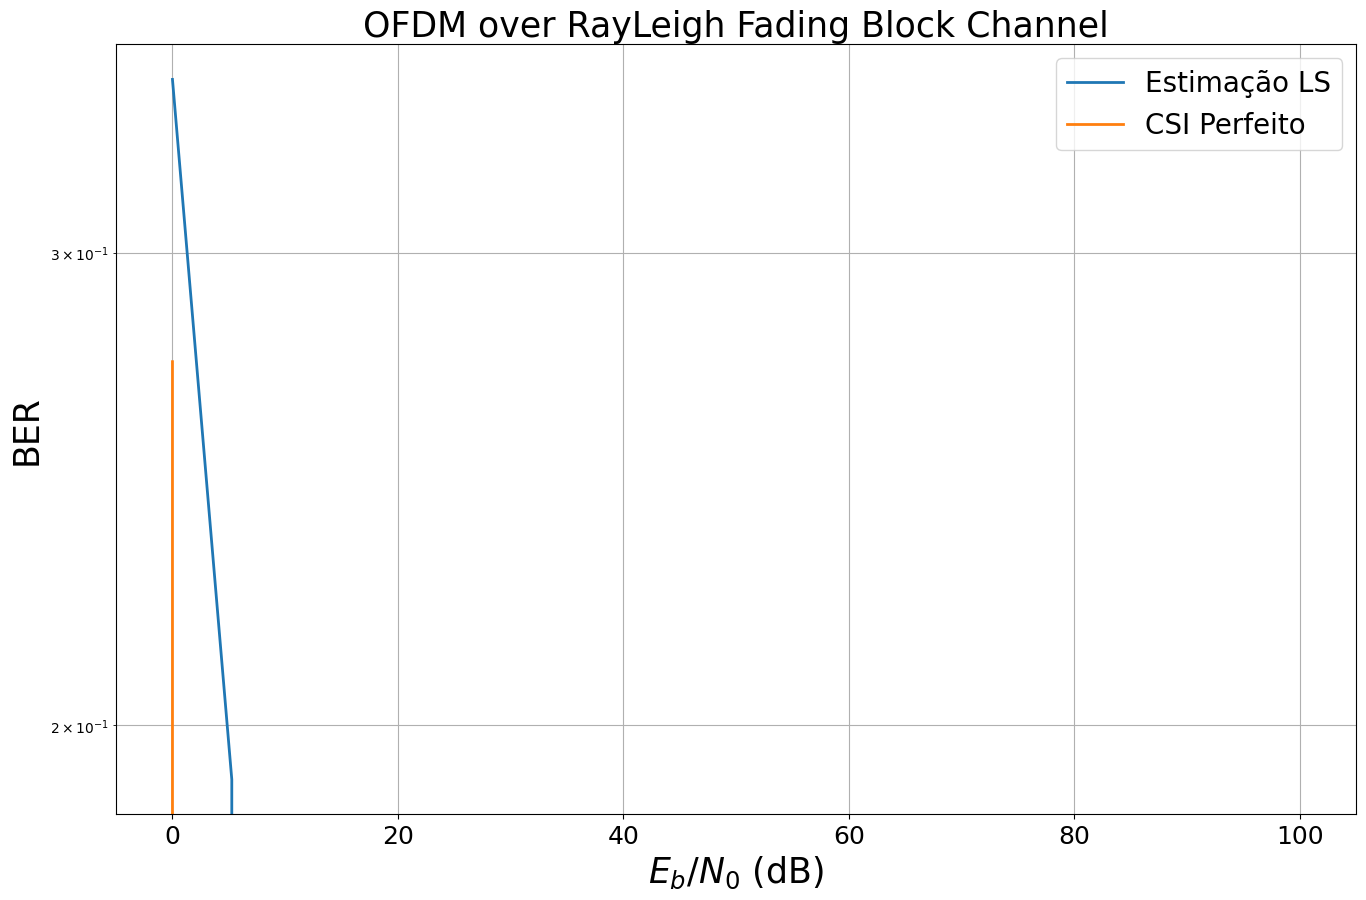

In [129]:
EBN0_DB_MIN = 0.0 # valor minimo de eb/no a ser simulado
EBN0_DB_MAX = 100.0 # valor maximo de eb/no a ser simulado
ber_plots = sn.utils.PlotBER("OFDM over RayLeigh Fading Block Channel")

model_ls = OFDMSystem(False) #simula o canal fora da ofdm, com 'least squares estimation'
ber_plots.simulate(model_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, 
                  legend="Estimação LS",
                  soft_estimates=True,
                  max_mc_iter=100, # faz 100 simulações de Monte-Carlo 
                  show_fig=False);

model_pcsi = OFDMSystem(True) #utiliza o ofdm para a simulação , csi significa informação de estado do canal, perfect csi significa q o canal está es condições ideais
ber_plots.simulate(model_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, 
                  legend="CSI Perfeito",
                  soft_estimates=True,
                  max_mc_iter=100, # faz 100 simulações de Monte-Carlo 
                  show_fig=False);

ber_plots();